## Here we encode chaotic trajectories into a fractal map
#### Direct inspiration from this video https://youtu.be/C5Jkgvw-Z6E

In [1]:
import numpy as np
from numpy import sin, cos, pi, exp, sqrt, arctan
import matplotlib.pyplot as plt

We start by defining the potential surface. <br>
Note that many options are availible -- and a physically reproducable model is unnecessary. <br>
All we need are potentials with nice derivatives, so 1/(x^2+y^2) will not work (not simply). <br>
Instead we opt for Gaussians, which of course lack singularities.

In [2]:
def V(x,y):
    #Three well potentials (distributed as points of equalateral triangle)
    v1 = A*exp(-((x-r*cos(theta))**2 + (y-r*sin(theta))**2)/w)-30
    v2 = A*exp(-((x-r*cos(theta+2*pi/3))**2 + (y-r*sin(theta+2*pi/3))**2)/w)-30
    v3 = A*exp(-((x-r*cos(theta+4*pi/3))**2 + (y-r*sin(theta+4*pi/3))**2)/w)-30
    #Background potential (one large Gaussian)
    vbkg = B*exp(-((x**2)+(y**2))/wbkg)-30
    return -np.array(v1+v2+v3+vbkg)

We now initialize our system -- single-threaded CPU runtime is exponential

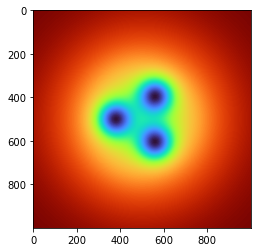

In [3]:
#Define the grid
res = 1000 #Note that the resolution will also dictate trajectory dynamics
xs, ys = np.linspace(-10,10,res), np.linspace(-10,10,res)
X, Y = np.meshgrid(xs, ys)

#Parameterize the potential
theta = pi/3
r = 2.5
A = 25
B = 25
w = 2.5
wbkg = 50

#See what we're working with
Z = V(X,Y)
plt.imshow(Z, cmap='turbo')
plt.show()

Next we compute the force field. <br>
This can be done via multiple methods 
<br> -- indeed, just using dV/di = V[i-1]-V[i+1] for each dimension i works fine.
<br> Here however we opt for np.gradient(), which yields F = [dV/dx, dV/dy] for more precision.

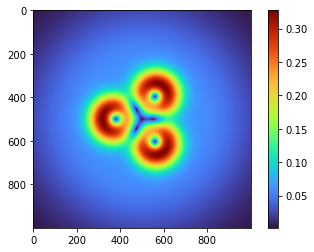

In [4]:
#Compute force and show magnitude
F = np.array(np.gradient(Z))
Fmag = sqrt(F[0]**2 + F[1]**2)
plt.imshow(Fmag, cmap='turbo')
plt.colorbar()
plt.show()

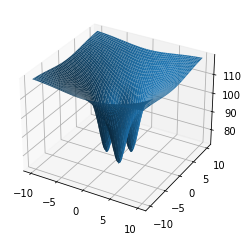

In [5]:
#If we want to see what it looks like in 3D...
#Importantly, your potential should not be negative, its minima should be > 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

Here we define some functions as well as the particle dictionary. <br>
The particle is just some data structure that can be updated -- it can be an array if you like.

In [14]:
#The particle dict is simple enough, currently ax and ay aren't updated
def particle():
    p = {
        'i': 0, 'm':1, 
        'x': 0, 'y': 0,
        'vx': 0, 'vy': 0,
        'ax': 0, 'ay': 0,
        }
    return p

#The force for a given position in the potential
def force(x, y):
    try: fx, fy = F[0][int(x)][int(y)], F[1][int(x)][int(y)]
    except: return 0, 0
    return -10*fx, -10*fy #multiplied by 10 for optimization

#Check convergence on attractor (based on small forces / accelerations)
#Note that this parameter (minforce) is part of the optimization
def converge(fx, fy):
    minforce = 0.1
    if fx < minforce and fy < minforce: return True
    else: return False

#Determine which attractor converged upon (degrees are optimized)
def quadrant(x,y):
    deg = np.degrees(arctan(y/x))
    x = (x-res/2)/res; y = (y-res/2)/res
    r = sqrt(x**2 + y**2)
    #Check if converged outside of attractors (including middle)
    if r < 0.1 or r > 0.8: q = 0
    #Check which attractor converged upon
    elif deg > 37 and deg < 41: q = 1
    elif deg > 41 and deg < 45: q = 2
    elif deg > 51 and deg < 55: q = 3
    else: q = 0 #Met force minimum, but missed attractor
    return q

#The update function does most of the work
#It calculates position(velocity(acceleration(F(x,y))))
def update(p, dt):
    
    #Mass is 1, but if not, divide by mass
    ax, ay = force(p['x'], p['y'])
    
    #This is the force except, for out of bounds / singularities
    if ax == 0 or ay == 0: return 0
    
    #Calculate velocity
    vx = p['vx'] + p['ax']*dt
    vy = p['vy'] + p['ay']*dt
    
    #Dampening is necessary for realism -- but should be kept very close to 1
    vx *= damp
    vy *= damp

    #Current position is a function of previous position, velocity, and acceleration
    x = p['x'] + p['vx']*dt + 0.5*p['ax']*dt**2
    y = p['y'] + p['vy']*dt + 0.5*p['ay']*dt**2
    
    #Update iteration and check for convergence (after certain number of iterations)
    p['i'] += 1
    if p['i'] > 1000 and converge(abs(p['ax']), abs(p['ay'])): 
        #If converged, we need to know which attractor it converged on
        q = quadrant(x,y)
        #print('Converged after', p['i'], 'iterations onto quadrant', q)
        return q
    
    #If not converged, update particle variables
    p['x'], p['y'] = x, y
    p['vx'], p['vy'] = vx, vy
    p['ax'], p['ay'] = ax, ay

    #Continue
    return -1

def display(X, Y):
    #imshow does not reflect actual matrix orientation
    plt.imshow(np.rot90(Z,k=3), cmap='turbo')
    plt.plot(X, Y, c='white', alpha=0.5)
    plt.scatter([X[0]], [Y[0]], color='white', label='start')
    plt.scatter([X[-1]], [Y[-1]], color='k', label='finish', zorder=3)
    plt.xlim(0,res); plt.ylim(0,res)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off'); #plt.legend()
    plt.show()

Now we get to the main program -- running the kinematics and plotting the fractal. <br>
First however, we showcase one chaotic trajectory for optimization purposes.

In [12]:
#Particle constants
dt = 0.1 #time descritization
damp = 0.9975 #dampening coefficent
limit = 10000 #maximum iterations without convergence

#Initialize particle and initial values
p1 = particle()
x0, y0 = np.random.uniform(0,res), np.random.uniform(0,res)
p1['x'], p1['y'] = x0, y0
p1['vx'], p1['vy'] = 0, 0
p1['ax'], p1['ay'] = 0, 0

#Save positions for plotting
X = []; Y = []
count = 0

#Particle dynamics loop
while count<limit:
    count += 1
    #Check for convergence
    Q = update(p1, dt)
    if Q>0 or Q==0: break
    X.append(p1['x'])
    Y.append(p1['y'])

Converged after 4651 iterations onto quadrant 2


If everything is in order, you should have a convergence report. <br>
You can display the trajectory like so.

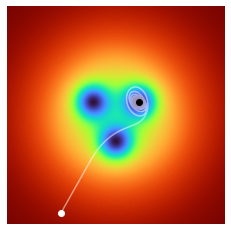

In [13]:
#You want a trajectory that loops around a bit, but not too much
#This mostly a function of A, B, damp, and res (all need to be well adjusted!)
display(X,Y)

Finally we bring out the big guns and run this from every point on the map. <br>
This will recover the awaited chaotic fractal set.

In [15]:
from tqdm import tqdm

img = []
for i in tqdm(range(res)):
    row = []
    for j in range(res):
        
        p1 = particle()
        p1['x'], p1['y'] = int(i), int(j)
        p1['vx'], p1['vy'] = 0, 0
        p1['ax'], p1['ay'] = 0, 0
        count = 0
        #Note we're including non-attractor convergences (q=0) for fun
        #Otherwise one would need to guarantee attractor convergence
        #Or fill in null img[] values afterwards, so that it is square
        while count<limit:
            count += 1
            Q = update(p1, dt)
            if Q>=0:
                row.append(Q)
                break
    
    img.append(row)

100%|██████████| 1000/1000 [4:19:30<00:00, 15.57s/it] 


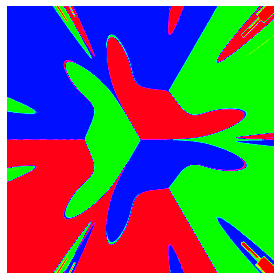

In [16]:
plt.imshow(np.asmatrix(img), cmap='hsv')
plt.axis('off'); plt.tight_layout()

#### anywallsocket@github.com 